# The geometry of hidden representations in protein language models

### Import libraries

In [6]:
import sys
sys.path.insert(0,'src/')

import numpy as np
import os

import plotly.graph_objects as go
from plotly.graph_objects import Layout
import plotly.io as pio
pio.renderers.default = 'svg'
 
from intrinsic_dimension import block_analysis, plot_ID, update_figure
from neighborhood_overlap import mapping, get_data, overlap_label, overlap_layer, plot_no, update_figure



## 1. Intrinsic Dimension

### Download ProteinNet data

In [13]:
path_id = '/Users/lucreziavaleriani/Desktop/mount_orfeo/data_repo/id/'

# choose the model(s) you are interested in between: 
# ProtBert, ProtT5, esm1b, esm1v, esm2-150M, esm2-15B, esm2-35M, esm2-3B, esm2-650M, esm2-8M
model_id = ['esm1b']
d_model_id = { model:{} for model in model_id}

for m in model_id:
    model = d_model_id[m]

    model['map'] = mapping[m]
    model['nlayer'] = model['map'][2]
    model['path'] = path_id + m + '/blocks/'
    model['id'] =  {l : [] for l in d_model_id[m]['nlayer']}

### Estimate ID

In [15]:
for m in model_id:
    model = d_model_id[m]
    id_model = model['id']

    for rep in id_model.keys():
        dist_mat = os.path.join(model['path'], 'rep' + str(rep) + '/rep-' + str(rep))
        dim, _, _ = block_analysis(dist_mat, blocks = list(range(1, 21)), fraction = 0.9)
        id_model[rep] = np.mean(dim)


### Plot ProteinNet ID curve

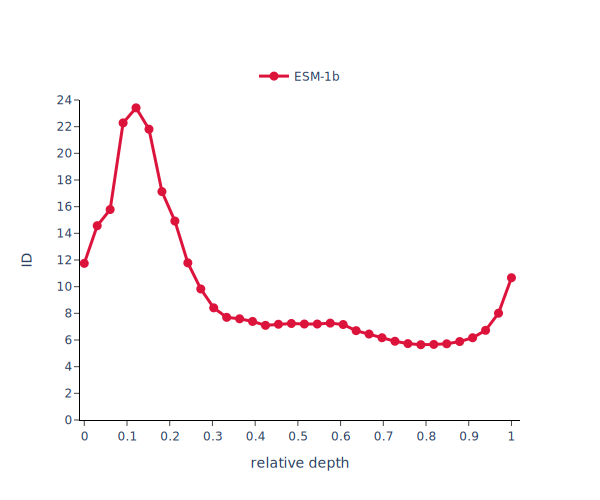

In [16]:
layout = Layout(plot_bgcolor='rgba(0,0,0,0)')
fig = go.Figure(layout = layout).set_subplots(1, 1, horizontal_spacing = 0.1, vertical_spacing = 0.02)

for m in model_id:
    model = d_model_id[m]
    nlayer = model['nlayer']
    id_model = model['id']
    model_map = model['map']

    plot_ID(fig, nlayer, list(id_model.values()), model_map[1], model_map[0])

update_figure(fig, w = 600, h= 500)


## 2. Neighboorhod Overlap 

### 2.1 Neighborhood rearrangements - ProteinNet

In [17]:
path_pnet = '/Users/lucreziavaleriani/Desktop/mount_orfeo/data_repo/no/pnet/'

# choose the model(s) you are interested in between: 
# ProtBert, ProtT5, esm1b, esm1v, esm2-150M, esm2-15B, esm2-35M, esm2-3B, esm2-650M, esm2-8M

model_pnet = ['esm2-35M','esm2-8M']
d_model_pnet = { model:{} for model in model_pnet}

for m in model_pnet:
    model = d_model_pnet[m]

    model['map'] = mapping[m]
    model['nlayer'] = len(model['map'][2]) - 1
    model['path'] = path_pnet + m + '/rep'


In [18]:
for m in model_pnet:
    model = d_model_pnet[m]
    path = model['path']
    nlayer = model['nlayer']

    model['ds'] = get_data(path, nlayer, ng = 20)

In [19]:
knn = 10

for m in model_pnet:
    model = d_model_pnet[m]
    nlayer = model['nlayer']
    ds = model['ds']

    model['overlap_first'] = np.array([overlap_layer(ds, l, 0, k = knn) for l in range(nlayer+1)])
    model['overlap_last'] = np.array([overlap_layer(ds, l, nlayer, k = knn) for l in range(nlayer+1)])
    model['overlap_next'] = np.array([overlap_layer(ds, l, l+1, k = knn) for l in range(nlayer)])

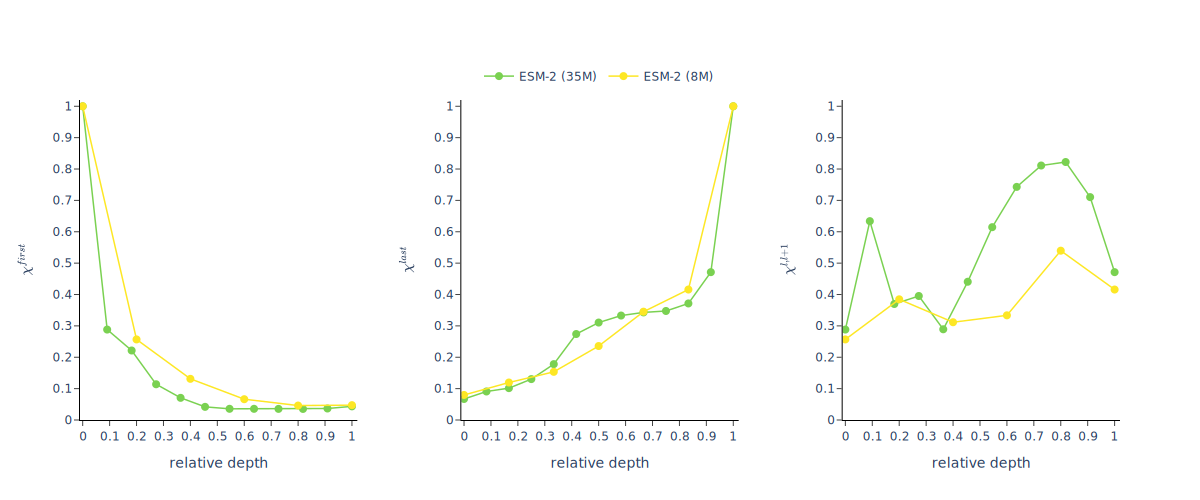

In [20]:
fig = go.Figure(layout=Layout(plot_bgcolor='rgba(0,0,0,0)')).set_subplots(1, 3, horizontal_spacing=0.1,vertical_spacing=0.02)

for m in model_pnet:
    model = d_model_pnet[m]
    nlayer = model['nlayer']
    model_map = model['map']

    plot_no(fig, nlayer-1, model['overlap_first'], model_map[1], model_map[0], r'$\chi^{first}$', 1, 1, True)
    plot_no(fig, nlayer, model['overlap_last'], model_map[1], model_map[0], r'$\chi^{last}$', 1, 2, False)
    plot_no(fig, nlayer-1, model['overlap_next'], model_map[1], model_map[0], r'$\chi^{l,l+1}$', 1, 3, False)

update_figure(fig, w = 1200, h = 500)

### 2.2 Remote Homology - SCOPE Superfamily

In [21]:
# choose the model you are interested in between: 'esm1b', 'esm1v', 'ProtBert', 'ProtT5', 'esm2-'...

path_sp = '/Users/lucreziavaleriani/Desktop/mount_orfeo/data_repo/no/rh_sp/'
label_path = '/Users/lucreziavaleriani/Desktop/mount_orfeo/data_repo/no/rh_sp/sp_lab.txt'

model_sp = ['esm2-35M','esm2-8M']
d_model_sp = { model:{} for model in model_sp}

# take mapping values for the model
for m in model_sp:
    model = d_model_sp[m]

    model['map'] = mapping[m]
    model['nlayer'] = len(model['map'][2]) - 1
    model['path'] = path_sp + m + '/rep'
    model['label_path'] = label_path

In [22]:
for m in model_sp:
    model = d_model_sp[m]

    model['ds'] = get_data(model['path'], model['nlayer'], model['label_path'], ng = 20)

In [23]:
knn = 10
for m in model_sp:
    model = d_model_sp[m]

    model['overlap_label'] = np.array(overlap_label(model['ds'], k = knn))

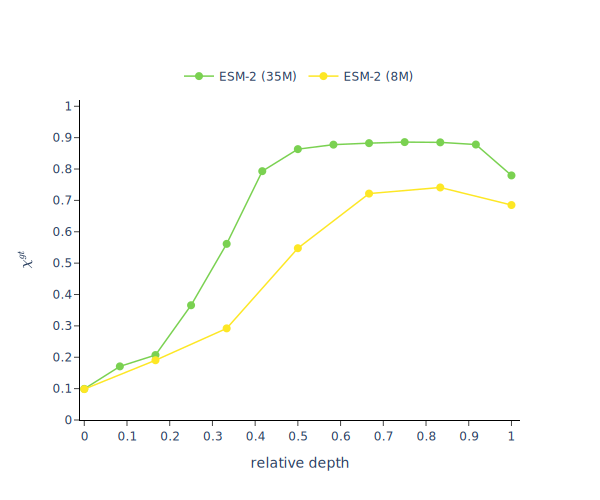

In [24]:
fig = go.Figure(layout=Layout(plot_bgcolor='rgba(0,0,0,0)')).set_subplots(1, 1, horizontal_spacing=0.1, vertical_spacing=0.02)

for m in model_sp:
    model = d_model_sp[m]
    model_map = model['map']
    nlayer = model['nlayer']

    plot_no(fig, nlayer, model['overlap_label'], model_map[1], model_map[0], r'$\chi^{gt}$')

update_figure(fig, w = 600, h= 500)